In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import vnn
import torchvision
from imp import reload

In [7]:
#CIFAR

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
for batch_idx, (data, labels) in enumerate(train_loader):
    break 

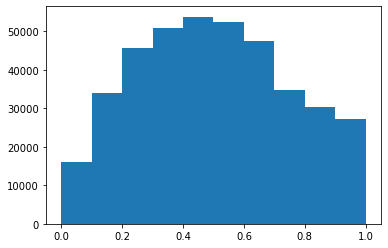

In [10]:
plt.hist(data.numpy().flatten())
plt.show()

In [6]:
reload(vnn)

def make_conv_net(mono):
    torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 96, 5, stride=2, mono=mono, first_layer=True),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 3, stride=2, mono=mono),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 3, stride=1, mono=mono),
                          vnn.tReLU(),
                          vnn.Flatten(),
                          vnn.Linear(10, 1536, 1200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 1200, 600, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 600, 1, mono=mono)).to(0)
    return model

def make_conv_net(mono):
    #torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 64*2, 5, stride=1, padding=4, mono=mono, first_layer=True),
                          vnn.nReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Conv2d(10, 64*2, 64*2, 5, stride=1, padding=4, mono=mono),
                          vnn.nReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Conv2d(10, 64*2, 64*2, 5, stride=1, padding=4, mono=mono),
                          vnn.nReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Flatten(),
                          vnn.Linear(10, 3136*2, 800, mono=mono),
                          vnn.nReLU(),
                          vnn.Linear(10, 800, 400, mono=mono),
                          vnn.nReLU(),
                          vnn.Linear(10, 400, 1, mono=mono)).to(0)
    return model

def make_conv_net(mono):
    torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 96*6, 5, stride=2, mono=mono, first_layer=True),
                          vnn.ctReLU(),
                          vnn.Conv2d(10, 96*6, 96*4, 3, stride=2, mono=mono),
                          vnn.ctReLU(),
                          vnn.Conv2d(10, 96*4, 96*2, 3, stride=1, mono=mono),
                          vnn.ctReLU(),
                          vnn.Flatten(),
                          vnn.Linear(10, 1536*2, 1200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 1200, 600, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 600, 1, mono=mono)).to(0)
    return model

def make_conv_net(mono):
    #torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 256, 3, stride=1, mono=mono, first_layer=True),
                          vnn.cnReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Conv2d(10, 256, 512, 3, stride=1, mono=mono),
                          vnn.cnReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Conv2d(10, 512, 128, 3, stride=1, mono=mono),
                          vnn.cnReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Flatten(),
                          vnn.Linear(10, 512, 512, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 512, 256, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 256, 1, mono=mono)).to(0)
    return model

def make_conv_net(mono):
    torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 256, 5, stride=2, mono=mono, first_layer=True),
                          vnn.ctReLU(),
                          vnn.Conv2d(10, 256, 256, 3, stride=2, mono=mono),
                          vnn.ctReLU(),
                          vnn.Conv2d(10, 256, 256, 3, stride=1, mono=mono),
                          vnn.ctReLU(),
                          vnn.Flatten(),
                          vnn.Linear(10, 4096, 1200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 1200, 600, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 600, 1, mono=mono)).to(0)
    return model



#conv = make_conv_net(True)
#data = torch.randn(64, 3, 32, 32)
#input = vnn.expand_input_conv(data, 10).to(0)
#out = conv(input)
#plt.hist(out.cpu().detach().numpy().flatten())
#out.std()
#out.shape

In [9]:
reload(vnn)

def eval_acc(model, loader):
    num_correct = 0
    total = 0
    for batch_idx, (data, labels) in enumerate(loader):
        input = vnn.expand_input_conv(data, 10).to(0)
        with torch.no_grad():
            out = model.forward(input)[..., 0]
        num_correct += (out.argmax(dim=1).cpu() == labels).int().sum().item()
        total += len(data)
    acc = num_correct / total
    return acc

def train_model_local(model, loader, filename):
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    acc_vals = np.array([])
    for epoch_idx in range(100):
        print(epoch_idx)
        epoch_loss = 0.
        epoch_correct = 0.
        for batch_idx, (data, labels) in enumerate(loader):
            input = vnn.expand_input_conv(data, 10).to(0)
            with torch.no_grad():
                out = model(input)[..., 0]
            loss = loss_fn(out, labels.to(0))
            epoch_loss += loss.item()
            epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
            opt.zero_grad()
            vnn.set_model_grads(model, out, labels.to(0))
            opt.step()
            for layer in model: layer.post_step_callback()
        print(epoch_loss / (batch_idx + 1))
        print(epoch_correct / 50000.)
        acc_vals = np.concatenate((acc_vals, [epoch_correct]))
        np.save(filename, acc_vals)
        
def train_model_bp(model, loader, filename):
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    acc_vals = np.array([])
    for epoch_idx in range(100):
        print(epoch_idx)
        epoch_loss = 0.
        epoch_correct = 0.
        for batch_idx, (data, labels) in enumerate(loader):
            input = vnn.expand_input_conv(data, 10).to(0)
            out = model(input)[..., 0]
            loss = loss_fn(out, labels.to(0))
            epoch_loss += loss.item()
            epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
            opt.zero_grad()
            loss.backward()
            opt.step()
            for layer in model: layer.post_step_callback()
        print(epoch_loss / (batch_idx + 1))
        print(epoch_correct / 50000.)
        acc_vals = np.concatenate((acc_vals, [epoch_correct]))
        np.save(filename, acc_vals)
        

In [10]:
#conv_mono = None
conv = make_conv_net(True)
train_model_bp(conv, train_loader, "results/conv_bp.npy")

#conv_mono = make_conv_net(True)
#train_model_bp(conv_mono, train_loader, "results/conv_mono_bp_2.npy")

#conv = make_conv_net(False)
#train_model_local(conv, train_loader, "results/conv_local.npy")

#conv_mono = make_conv_net(True)
#train_model_local(conv_mono, train_loader, "results/conv_mono_local.npy")

0
Instantiated t with shape (10, 256, 14, 14)
Instantiated t with shape (10, 256, 6, 6)
Instantiated t with shape (10, 256, 4, 4)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
776.2988092466388
0.26022
1
7.22728678210617
0.27962
2
4.0486733462194655
0.28542
3
3.29658877666649
0.29786
4
2.8064356213030606
0.30564
5
2.462614848180805
0.31864
6
2.195246292197186
0.33054
7
2.070845104849247
0.33978
8
1.9820757954931625
0.35588
9
1.895630913317356
0.372
10
1.778263650891726
0.38702
11
1.7199971657579818
0.40184
12
1.6654745102538477
0.41438
13
1.6560956791538717
0.42392
14
1.6020305467688518
0.4402
15
1.5577343479751626
0.45458
16
1.5431745345025416
0.46394
17
1.4861908416309015
0.47806
18
1.4642804040933204
0.48628
19
1.4196737397967092
0.50154
20
1.3876129044291308
0.511
21
1.3822697547390639
0.5183
22
1.3748394558801675
0.52572
23
1.316214964517852
0.54002
24
1.2784760495280976
0.55276
25
1.252726855028011
0.55978
26
1.2279501325639008
0.57188
27
1.203179956397

KeyboardInterrupt: 

In [24]:

#for p in conv.parameters():
#    #print(p.min().item(), p.max().item())
eval_acc(conv, test_loader)

0.6671

In [3]:
x1 = np.load("results/conv_bp.npy")
x2 = np.load("results/conv_mono_bp.npy")
x3 = np.load("results/conv_local.npy")
x4 = np.load("results/conv_mono_local.npy")



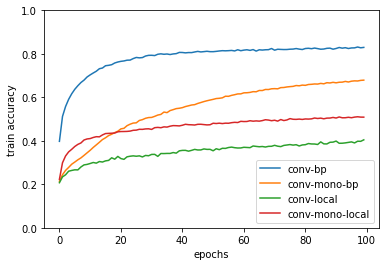

In [5]:
N = 50000.
plt.plot(x1/N, label="conv-bp")
plt.plot(x2/N, label="conv-mono-bp")
plt.plot(x3/N, label="conv-local")
plt.plot(x4/N, label="conv-mono-local")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("train accuracy")
plt.xlabel("epochs")
plt.savefig("figs/conv_acc.pdf", bbox_inches="tight")


In [32]:
for batch_idx, (data, labels) in enumerate(train_loader):
    input = vnn.expand_input_conv(data, 10) #.to(0)
    break 

In [33]:
out = conv(input.to(0))[..., 0].detach().cpu()



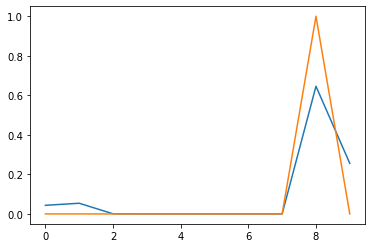

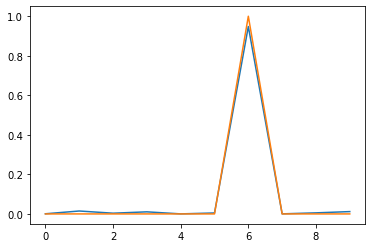

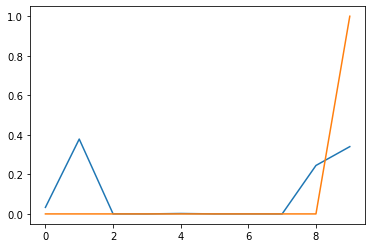

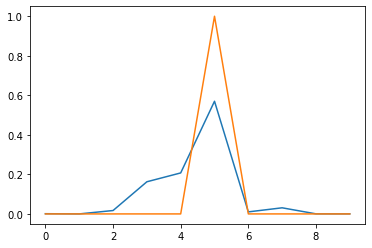

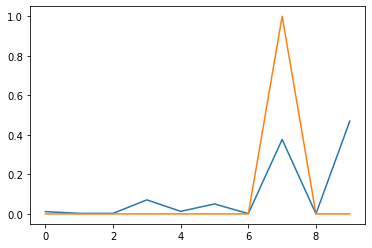

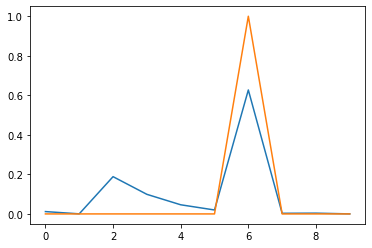

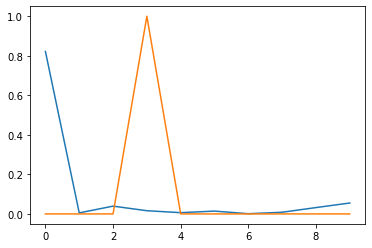

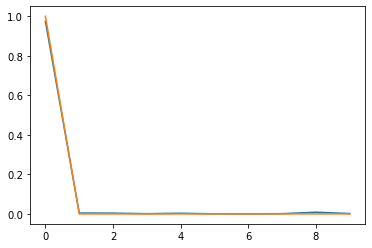

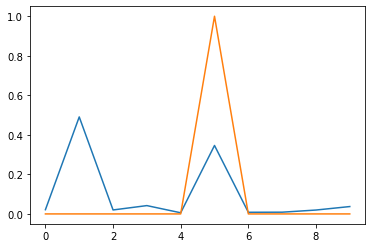

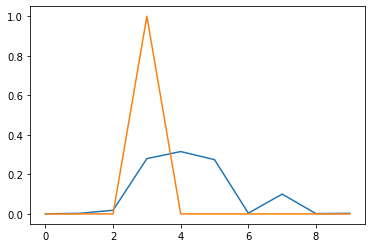

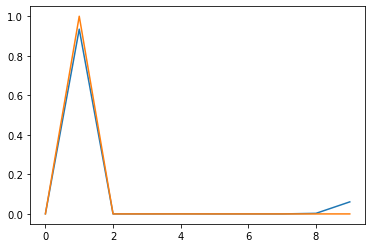

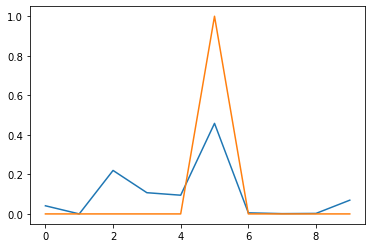

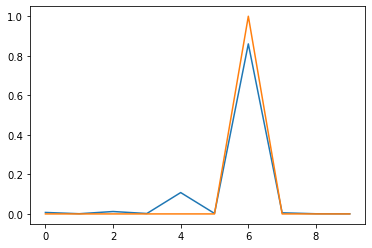

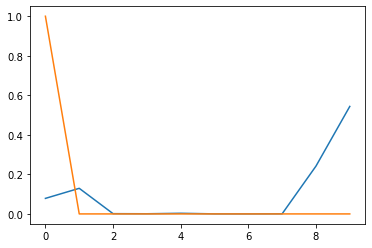

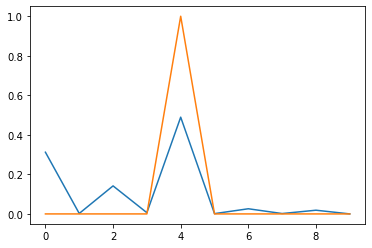

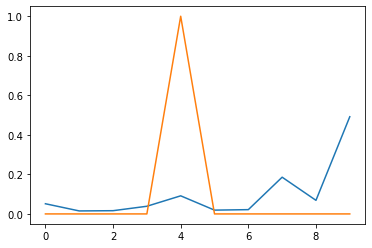

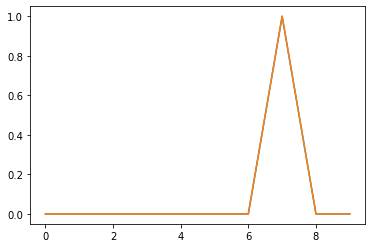

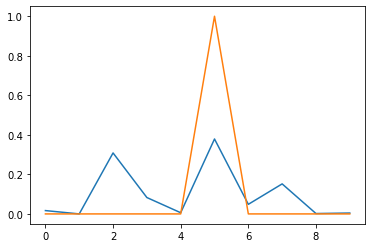

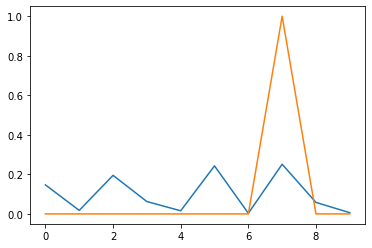

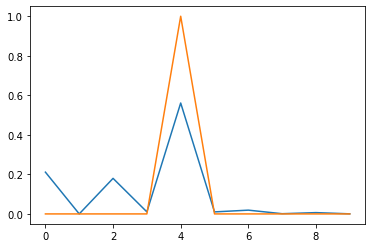

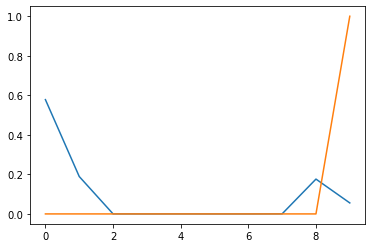

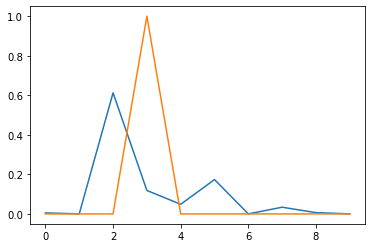

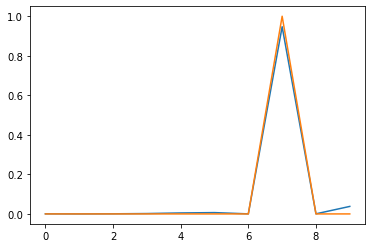

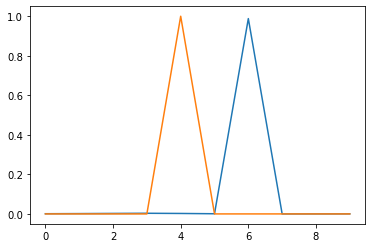

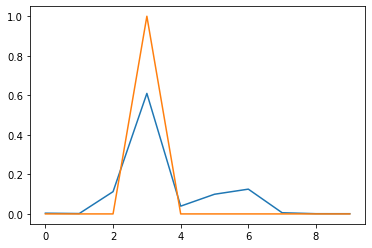

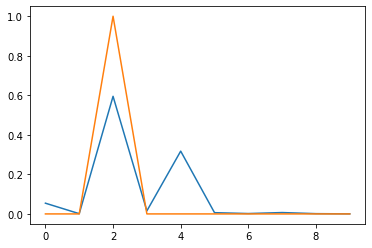

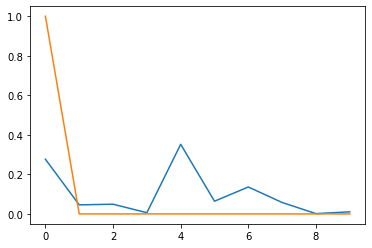

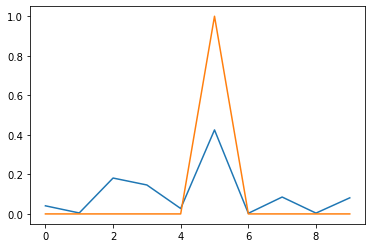

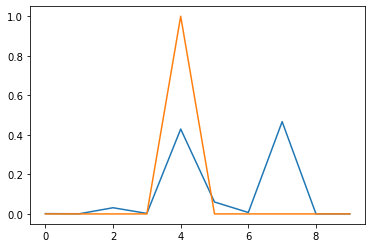

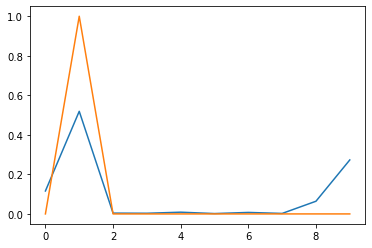

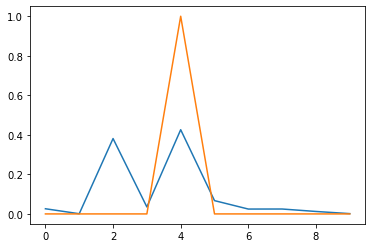

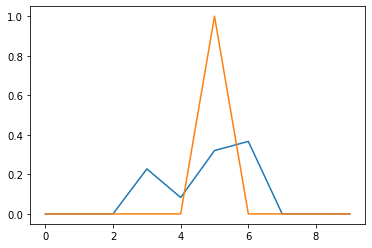

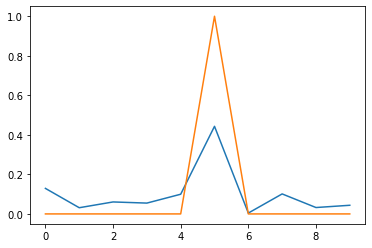

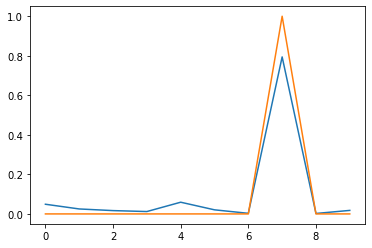

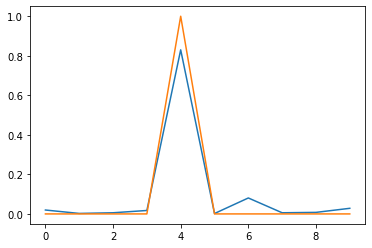

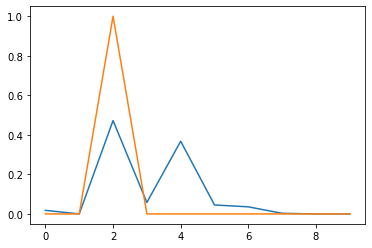

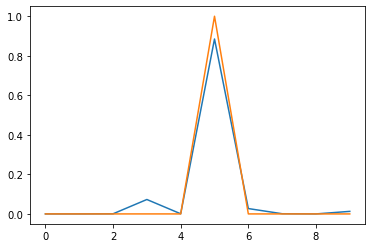

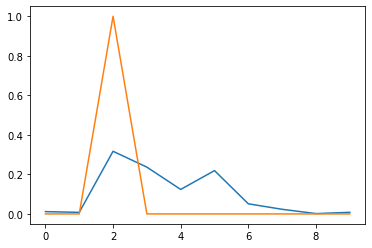

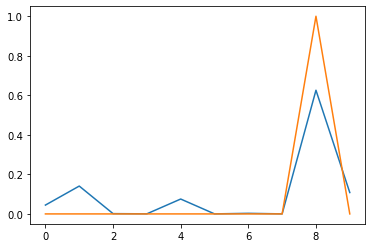

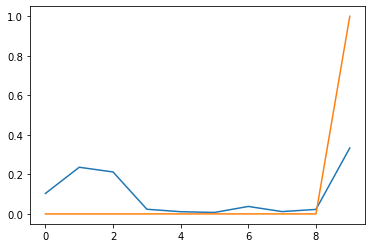

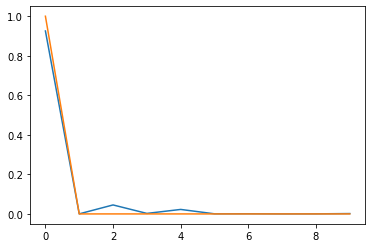

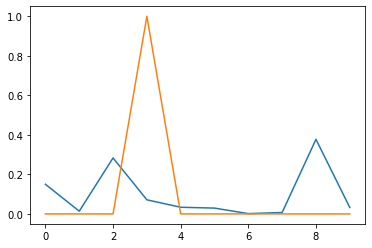

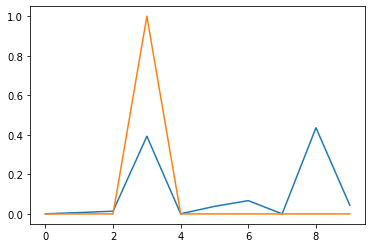

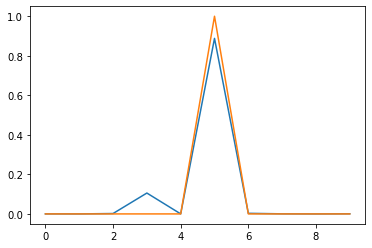

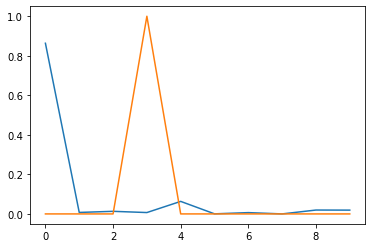

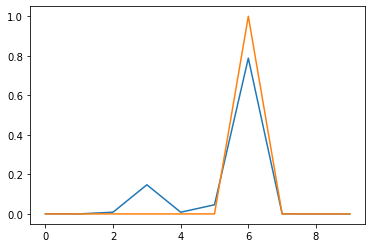

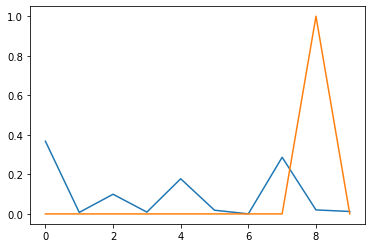

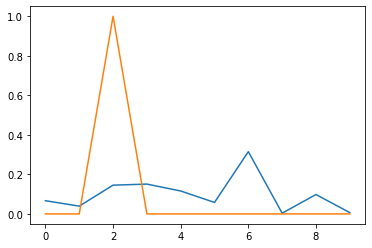

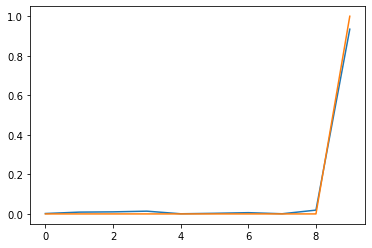

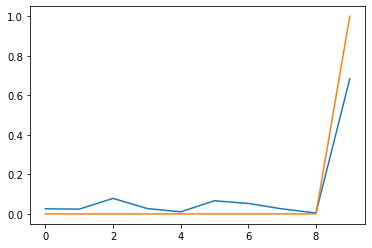

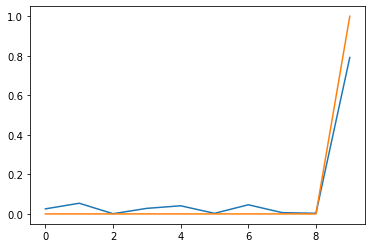

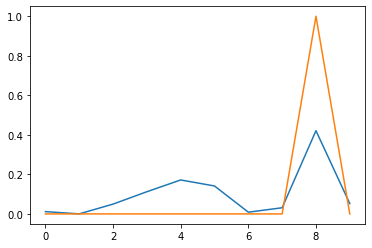

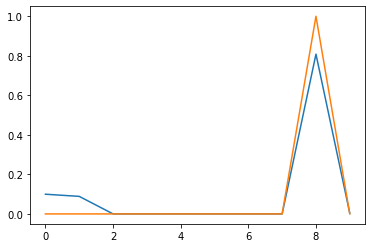

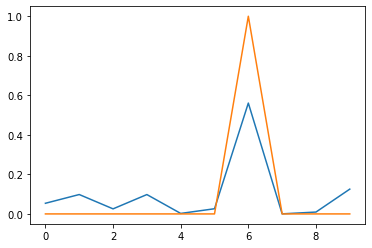

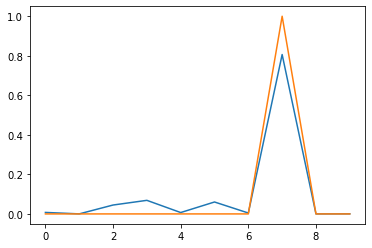

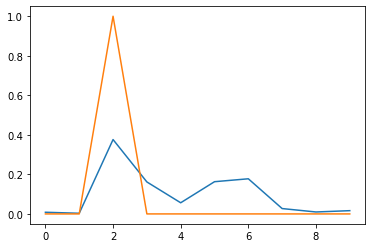

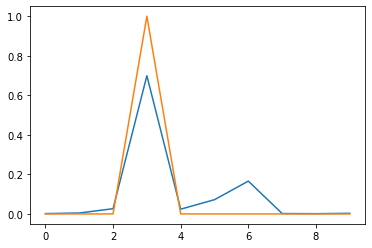

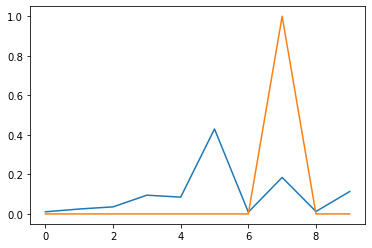

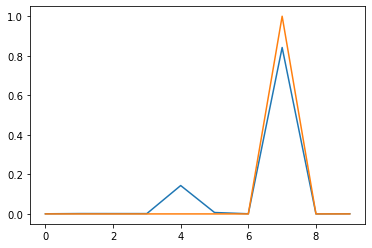

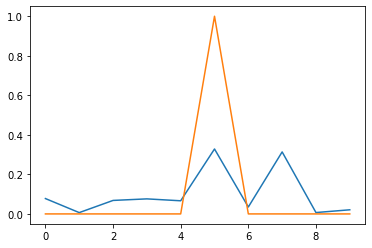

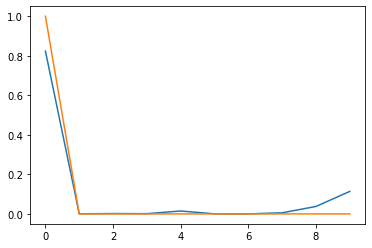

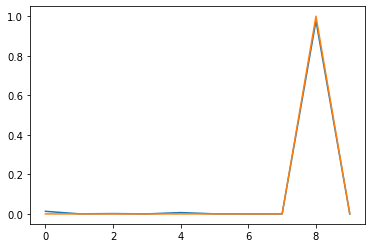

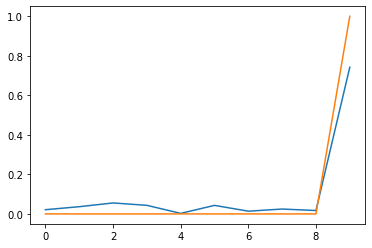

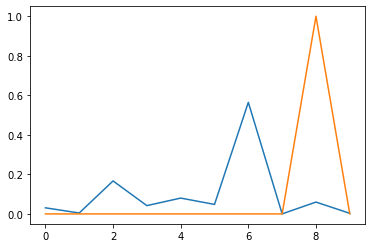

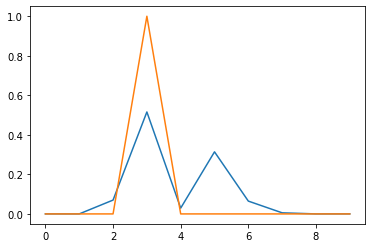

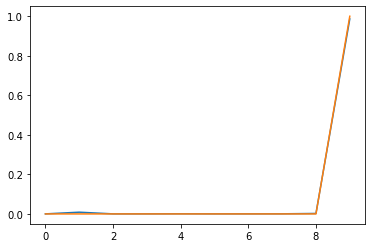

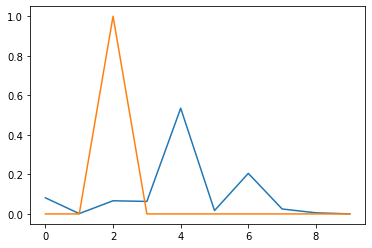

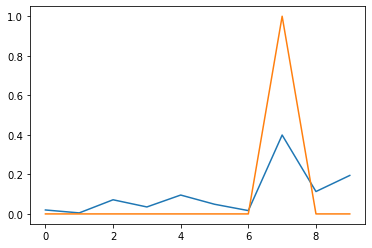

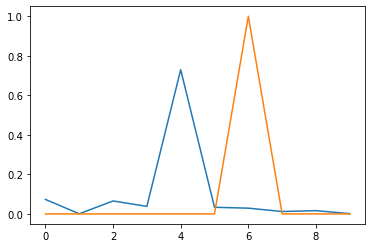

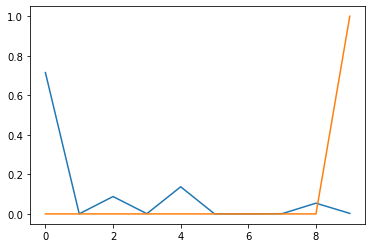

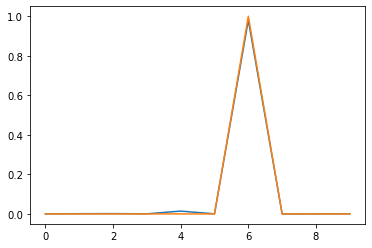

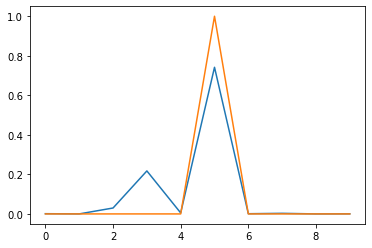

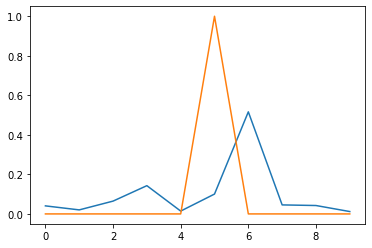

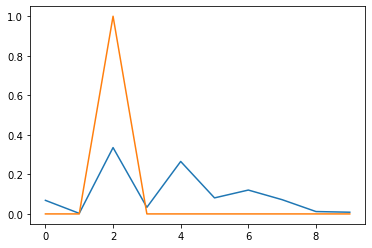

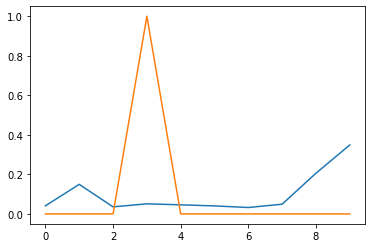

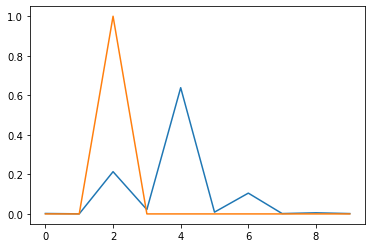

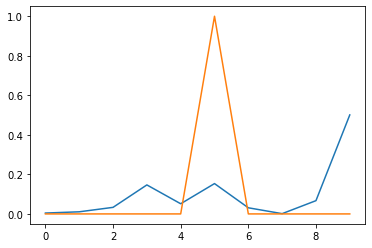

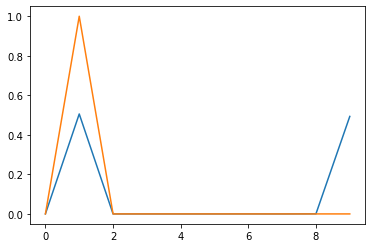

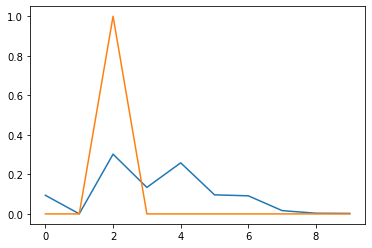

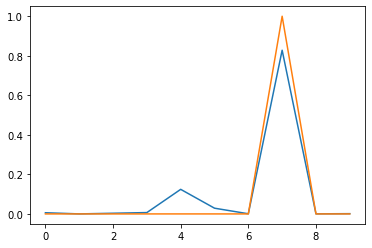

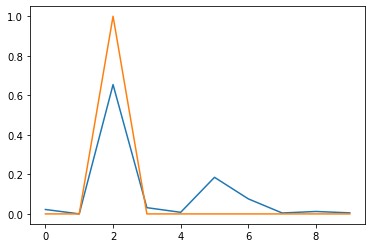

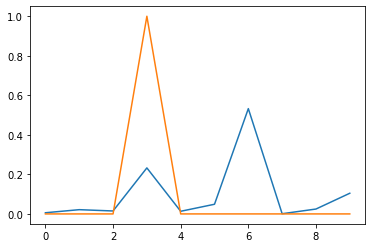

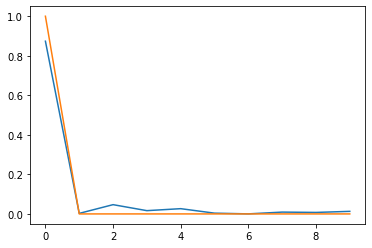

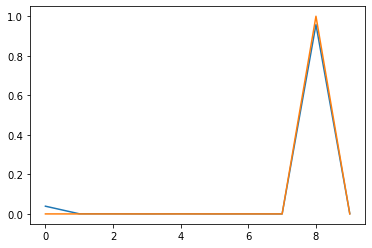

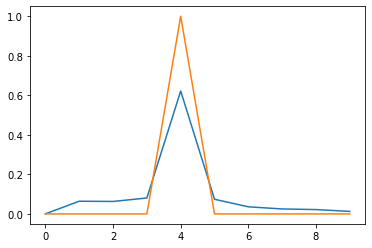

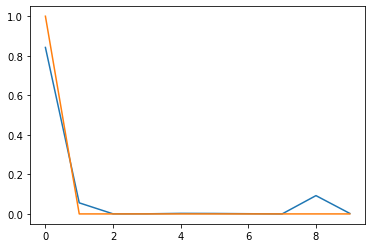

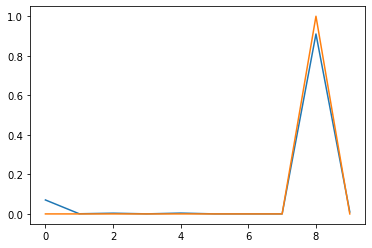

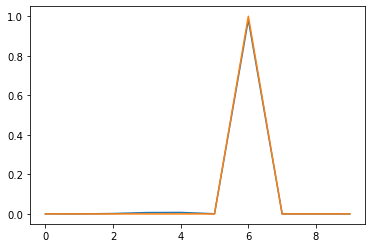

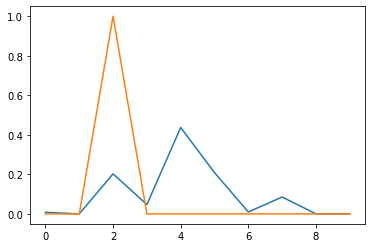

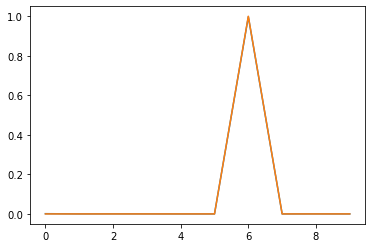

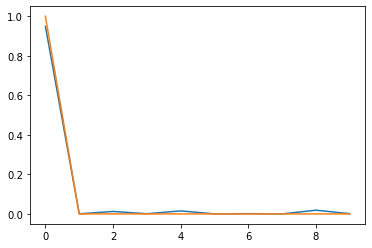

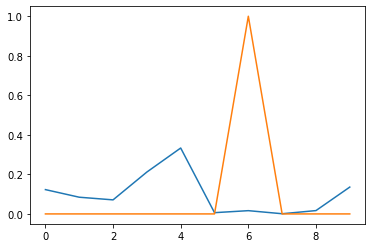

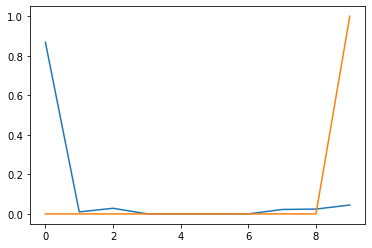

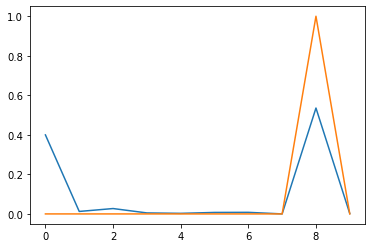

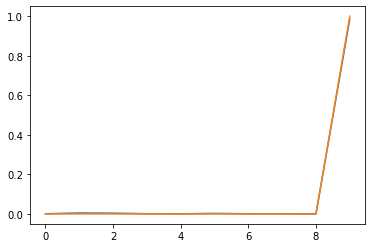

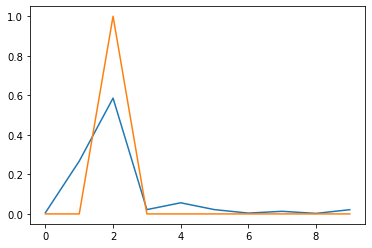

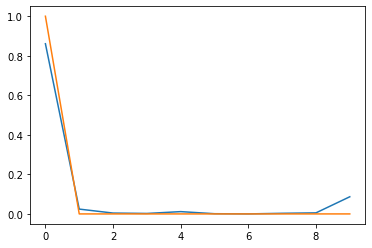

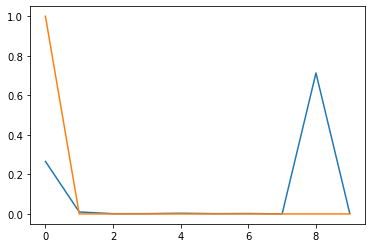

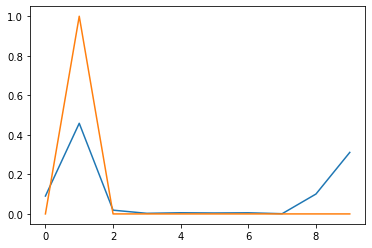

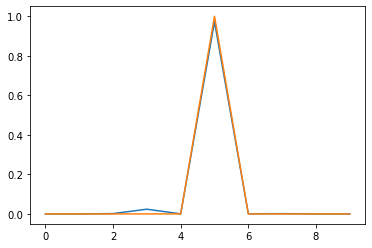

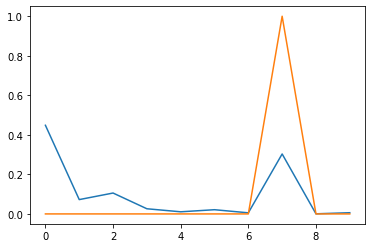

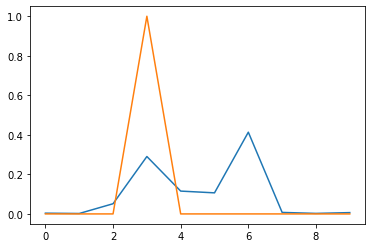

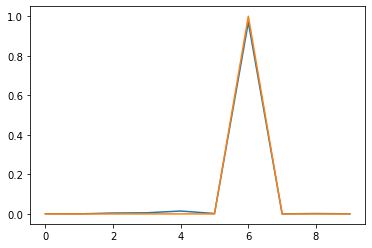

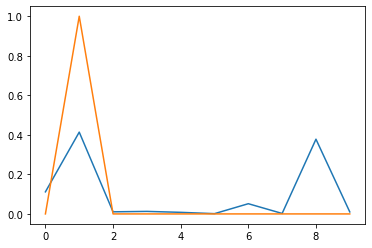

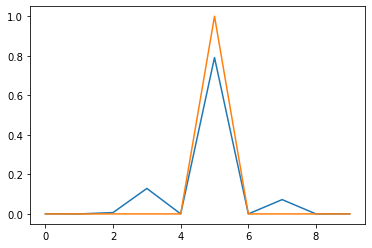

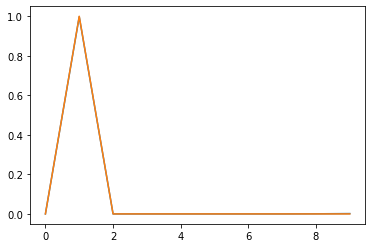

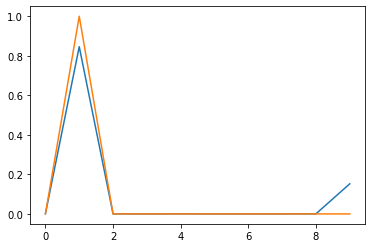

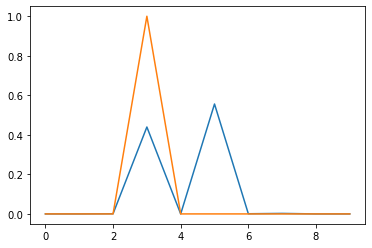

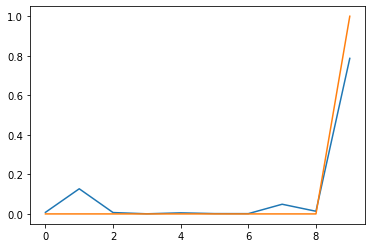

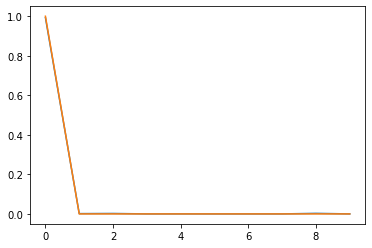

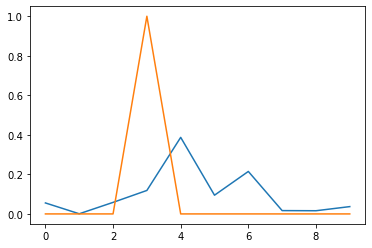

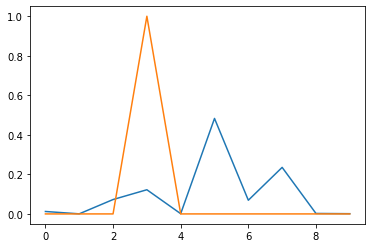

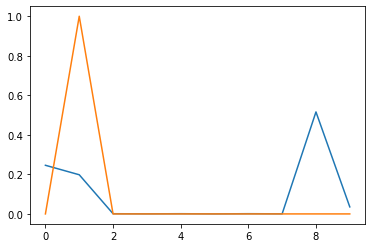

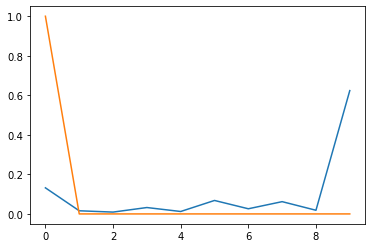

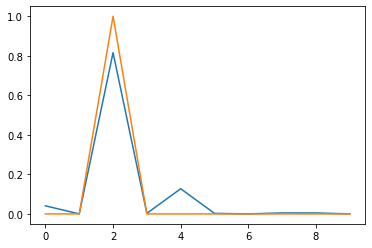

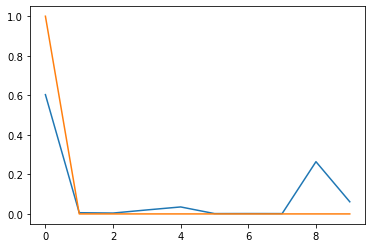

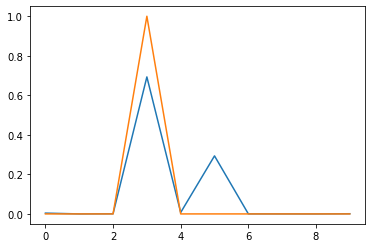

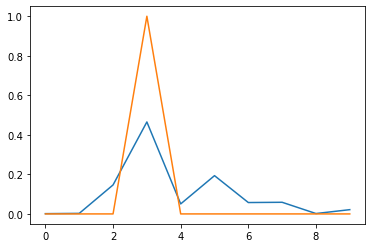

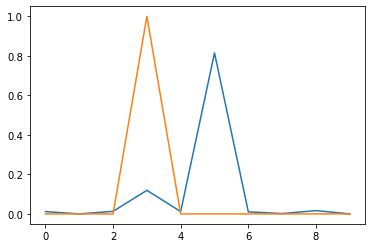

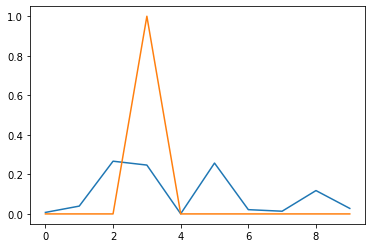

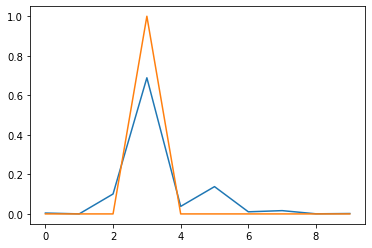

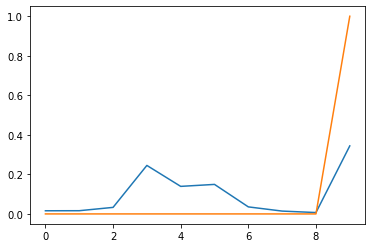

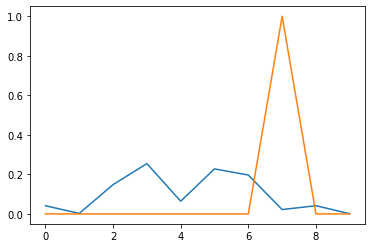

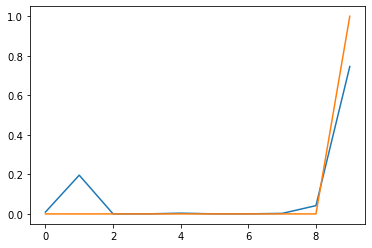

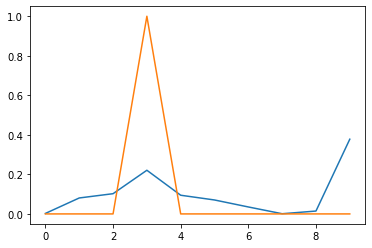

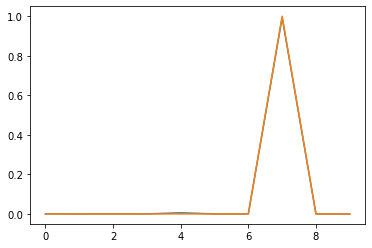

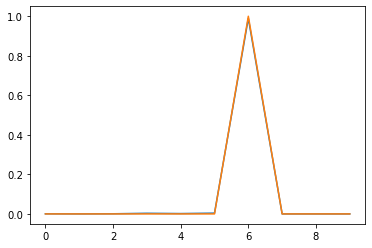

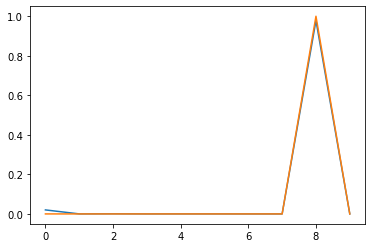

In [34]:
for i in range(128):
    plt.plot(F.softmax(out[i], dim=0))
    plt.plot(torch.eye(10)[labels[i]])
    plt.show()
    

In [11]:
model = nn.Sequential(nn.Conv2d(3, 64, 5, stride=1, padding=4),
                      nn.ReLU(),
                      nn.AvgPool2d(2),
                      nn.Conv2d(64, 64, 5, stride=1, padding=4),
                      nn.ReLU(),
                      nn.AvgPool2d(2),
                      nn.Conv2d(64, 64, 5, stride=1, padding=4),
                      nn.ReLU(),
                      nn.AvgPool2d(2),
                      nn.Flatten(),
                      nn.Linear(3136, 1200),
                      nn.ReLU(),
                      nn.Linear(1200, 600),
                      nn.ReLU(),
                      nn.Linear(600, 10)).to(0)

In [13]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr=1e-4)
acc_vals = np.array([])
for epoch_idx in range(100):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        input = data.to(0)
        out = model(input)
        loss = loss_fn(out, labels.to(0))
        epoch_loss += loss.item()
        epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 50000.)
    acc_vals = np.concatenate((acc_vals, [epoch_correct]))
    #np.save(filename, acc_vals)

0
0.013297333293046583
0.99594
1
0.001746283521440447
0.99982
2
0.0008398372969089036
0.99988
3
0.0004490260925127433
0.99994
4
0.00030419948998686966
0.99994
5
0.0001464190890800337
1.0
6


KeyboardInterrupt: 

In [15]:
num_correct = 0
total = 0
for batch_idx, (data, labels) in enumerate(test_loader):
    input = data.to(0)
    out = model.forward(input)
    num_correct += (out.argmax(dim=1).cpu() == labels).int().sum().item()
    total += len(data)
acc = num_correct / total
acc


0.7479

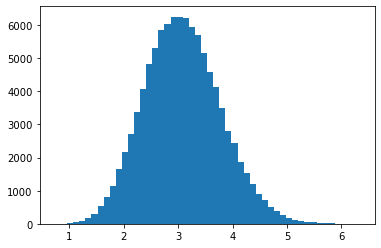

3.0563835614560144

In [6]:
x = np.random.normal(0, 1, (100000, 10))
#x = x / np.linalg.norm(x, axis=1, keepdims=True)
#p = x**2
#ent = (p * np.log(p)).sum(axis=1)
ent = np.linalg.norm(x, axis=1)
plt.hist(ent, bins=50)
plt.show()

np.percentile(ent, 50)

In [19]:
x = np.random.normal(0, 1, (1000000, 10))
n = np.linalg.norm(x, axis=1)
np.mean(n > 3.056)

0.500482

In [7]:
a = torch.randn(5, 5, 5)
a.median(dim=0)[0]

tensor([[ 0.3720, -0.4954, -0.4362, -0.5019, -0.0772],
        [-0.2563, -0.2433, -0.0301, -0.0500, -0.0517],
        [-0.2153,  0.3965,  0.2884, -0.2080, -0.9300],
        [ 1.3020,  0.0051, -0.3125,  0.1872, -0.1444],
        [ 0.7358, -0.3308,  0.5789, -0.8718,  1.0580]])

In [9]:
n = torch.randn(10, 5, 5, 5)
mask = (n >= n.median(dim=tuple(range(1, len(n.shape))))[0]).float()

TypeError: median() received an invalid combination of arguments - got (dim=tuple, ), but expected one of:
 * ()
      didn't match because some of the keywords were incorrect: dim
 * (name dim, bool keepdim)
 * (int dim, bool keepdim)


In [14]:
n.median(dim=0)

torch.return_types.median(
values=tensor([[[ 2.5886e-02, -2.6325e-01, -3.2295e-01, -1.3219e-01, -2.6950e-01],
         [-1.0745e+00, -8.1026e-01, -5.9388e-01, -1.5581e-01, -2.8749e-01],
         [ 1.1161e-01,  9.9493e-02, -1.0267e+00, -3.5213e-02, -5.6028e-01],
         [-6.7428e-01,  1.2401e-02, -3.4547e-01,  3.7565e-01, -3.9812e-01],
         [-5.5950e-01, -3.7957e-01, -6.1112e-01, -6.4801e-01, -9.4177e-02]],

        [[ 5.7161e-01,  1.1645e-01, -2.1906e-01,  6.1846e-02, -9.6730e-02],
         [-5.4614e-01, -6.8015e-01, -6.7080e-01, -8.0873e-01,  2.3164e-01],
         [ 1.4957e-01,  1.9743e-01,  3.0359e-01,  3.9449e-01,  1.1012e-01],
         [ 5.9752e-02, -3.7924e-01, -2.8385e-01, -2.1487e-01,  4.3365e-01],
         [-3.6409e-01, -1.8598e-02, -7.2651e-02,  4.2721e-01, -2.5729e-01]],

        [[ 2.3521e-01,  2.1395e-01,  5.4162e-01, -2.2052e-01,  4.1263e-02],
         [-1.1146e-01, -6.7546e-01, -6.4033e-02, -2.4090e-01, -3.5063e-01],
         [-1.6877e-01, -7.9056e-01,  9.3324e-02, -

In [22]:
def f():
    if 1 == 3:
        print(1)
    #comment
    #comment
    else:
        print(2)

f()

2
